# Stock Price Prediction

## Aim of the Project

The aim of this project is to **predict stock prices for the RELIANCE.NS**. This involves:

1. **Data Preparation**: Cleaning and preprocessing historical stock data to make it suitable for training model.
2. **Feature Engineering**: Creating relevant input features, such as moving averages, volume trends, and technical indicators, for accurate predictions.
3. **Model Development**: Designing, training, and evaluating  models  to predict future stock prices.
4. **Evaluation and Insights**: Comparing model performance using metrics like Mean Squared Error (MSE) and analyzing the predictions to provide actionable insights for financial decision-making.


## Data Preparation

In [118]:
import cupy as cp
import numpy as np
import pandas as pd
from scipy import stats

import yfinance as yf # Yahoo Finance to import dataset
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [3]:
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)

In [4]:
stock = "RELIANCE.NS"
reliance_data = yf.download(stock, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [5]:
reliance_data.to_csv("reliance_stock_data.csv")

In [6]:
reliance_data.head()

Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2015-01-27,183.482697,185.061505,181.718137,184.277253,17939876
2015-01-28,187.156265,187.765098,182.873865,182.873865,19298126
2015-01-29,191.810150,192.862689,187.166581,187.207856,36117653
2015-01-30,188.889877,192.191970,187.599994,191.933988,21746801
2015-02-02,187.403931,189.849540,186.918936,189.054970,19302710


In [7]:
df = pd.DataFrame(reliance_data)

In [8]:
df.shape

(2469, 5)

In [9]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2015-01-27,183.482697,185.061505,181.718137,184.277253,17939876
2015-01-28,187.156265,187.765098,182.873865,182.873865,19298126
2015-01-29,191.810150,192.862689,187.166581,187.207856,36117653
2015-01-30,188.889877,192.191970,187.599994,191.933988,21746801
2015-02-02,187.403931,189.849540,186.918936,189.054970,19302710


In [10]:
# Flatten MultiIndex columns to single level
df.columns = df.columns.get_level_values(0)  # Get first level only ('Close', 'High', etc)

# Display result
df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-27,183.482697,185.061505,181.718137,184.277253,17939876
2015-01-28,187.156265,187.765098,182.873865,182.873865,19298126
2015-01-29,191.810150,192.862689,187.166581,187.207856,36117653
2015-01-30,188.889877,192.191970,187.599994,191.933988,21746801
2015-02-02,187.403931,189.849540,186.918936,189.054970,19302710


In [11]:
# Remove multi-index columns, keep only base column names
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Convert index to datetime
df.index = pd.to_datetime(df.index)

# Print result
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-01-27,183.482697,185.061505,181.718137,184.277253,17939876
2015-01-28,187.156265,187.765098,182.873865,182.873865,19298126
2015-01-29,191.810150,192.862689,187.166581,187.207856,36117653
2015-01-30,188.889877,192.191970,187.599994,191.933988,21746801
2015-02-02,187.403931,189.849540,186.918936,189.054970,19302710


In [12]:
# Reset index to make Date a column
df = df.reset_index()

# Verify columns including Date
print("Columns after reset:", df.columns)

Columns after reset: Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [13]:
print(df.columns)

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [14]:
df.head()

,Date,Close,High,Low,Open,Volume
0,2015-01-27,183.482697,185.061505,181.718137,184.277253,17939876
1,2015-01-28,187.156265,187.765098,182.873865,182.873865,19298126
2,2015-01-29,191.810150,192.862689,187.166581,187.207856,36117653
3,2015-01-30,188.889877,192.191970,187.599994,191.933988,21746801
4,2015-02-02,187.403931,189.849540,186.918936,189.054970,19302710


In [15]:
df.isna().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

## Stock Price Dataset Description

The dataset contains daily trading information for stock prices with the following features:

### Column Descriptions:
- **Date**: Trading date (datetime)
- **Close**: Stock's closing price for the day (Dependent Feature/Target Feature)
- **High**: Highest trading price during the session
- **Low**: Lowest trading price during the session
- **Open**: Stock's opening price for the day
- **Volume**: Total number of shares traded

## Exploratory Data Analysis

In [16]:
numeric_columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df[numeric_columns].describe()

,Close,High,Low,Open,Volume
count,2469.000000,2469.000000,2469.000000,2469.000000,2.469000e+03
mean,735.417396,743.452865,728.040478,735.969607,1.841687e+07
std,421.630684,425.555956,418.060217,421.968069,1.354996e+07
min,167.323090,168.757435,164.371848,168.530423,1.705656e+06
25%,341.333984,344.737772,338.879384,341.246734,1.067109e+07
50%,648.492920,656.673591,640.801438,649.949823,1.462467e+07
75%,1128.266357,1136.977673,1118.600547,1128.664558,2.107781e+07
max,1590.069946,1597.916527,1574.774022,1593.595776,1.426834e+08


In [18]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 6)

C:\Users\linar\AppData\Local\Temp\ipykernel_15984\1559360635.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Time Series Analysis

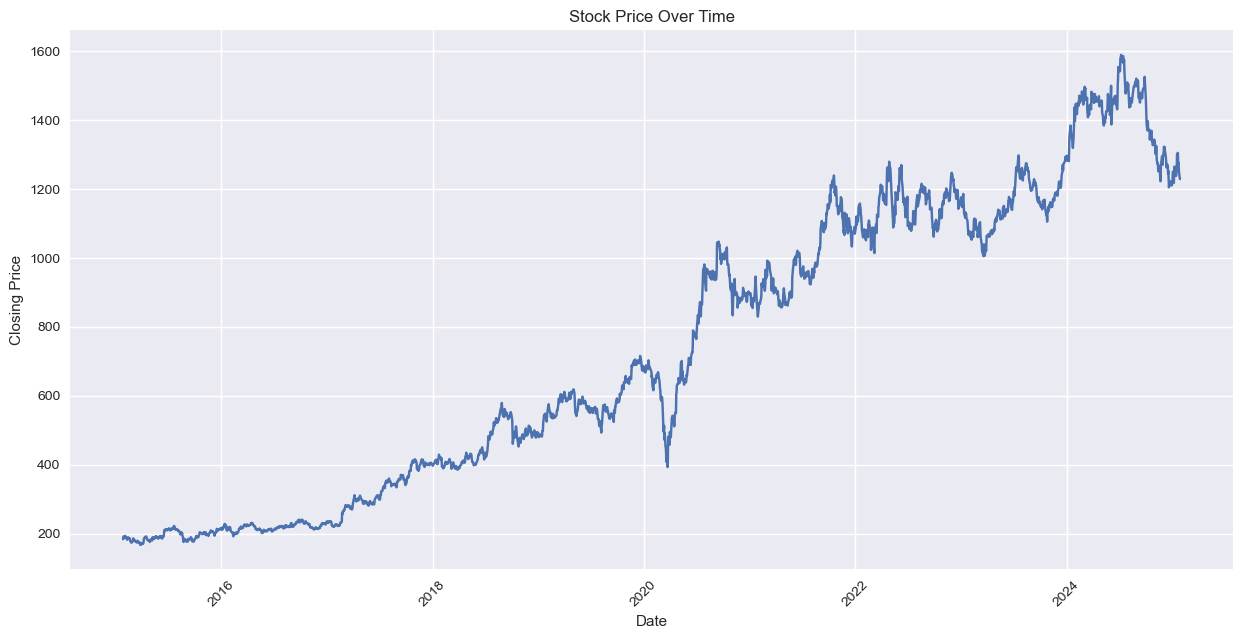

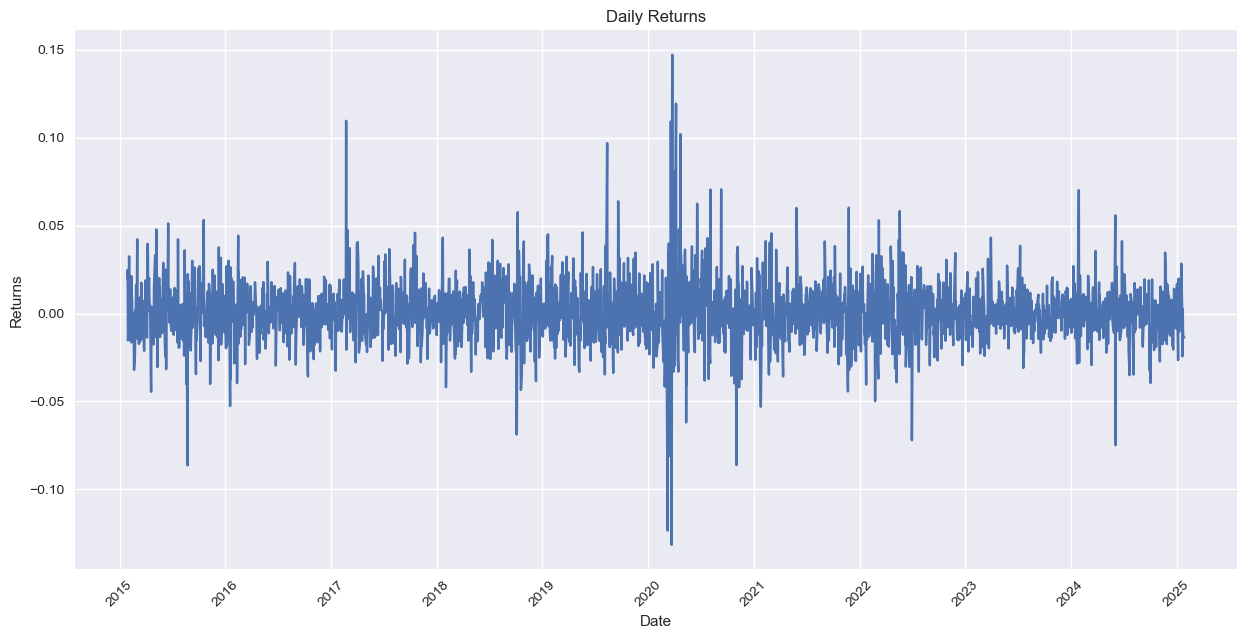

In [19]:
# Closing Price Over Time
plt.figure(figsize=(15, 7))
plt.plot(df['Date'], df['Close'])
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.show()

# Daily Returns
df['Returns'] = df['Close'].pct_change()
plt.figure(figsize=(15, 7))
plt.plot(df['Date'], df['Returns'])
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.xticks(rotation=45)
plt.show()

### Volume Analysis

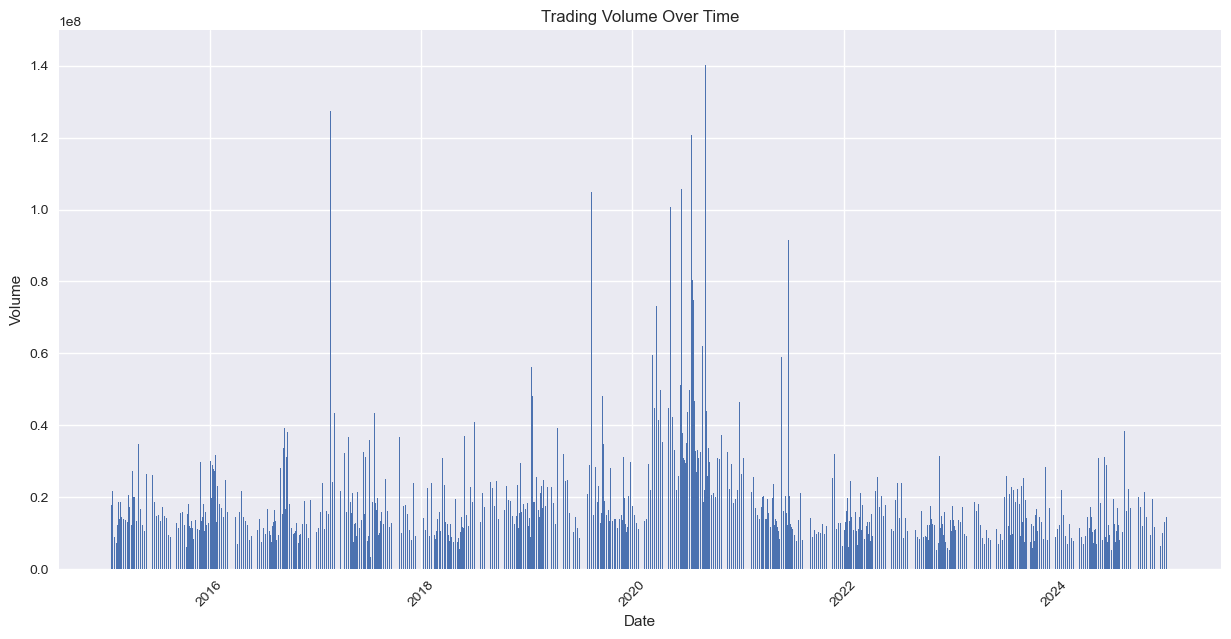

In [20]:
# Trading Volume Over Time
plt.figure(figsize=(15, 7))
plt.bar(df['Date'], df['Volume'])
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.show()

### Statistical Features

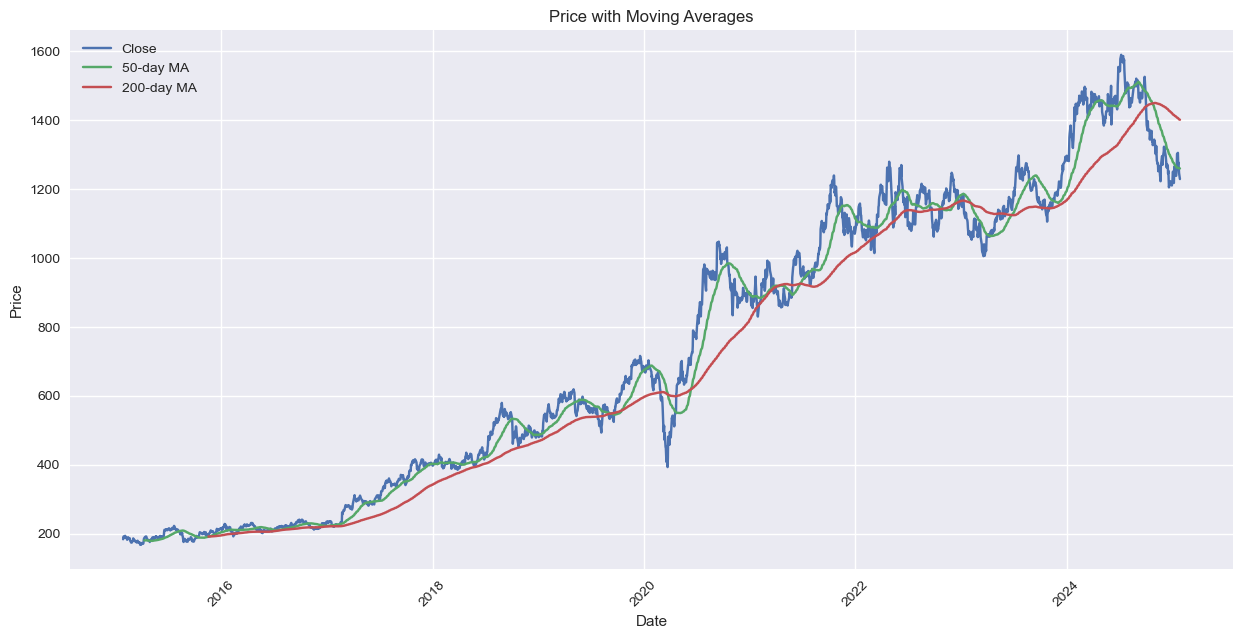

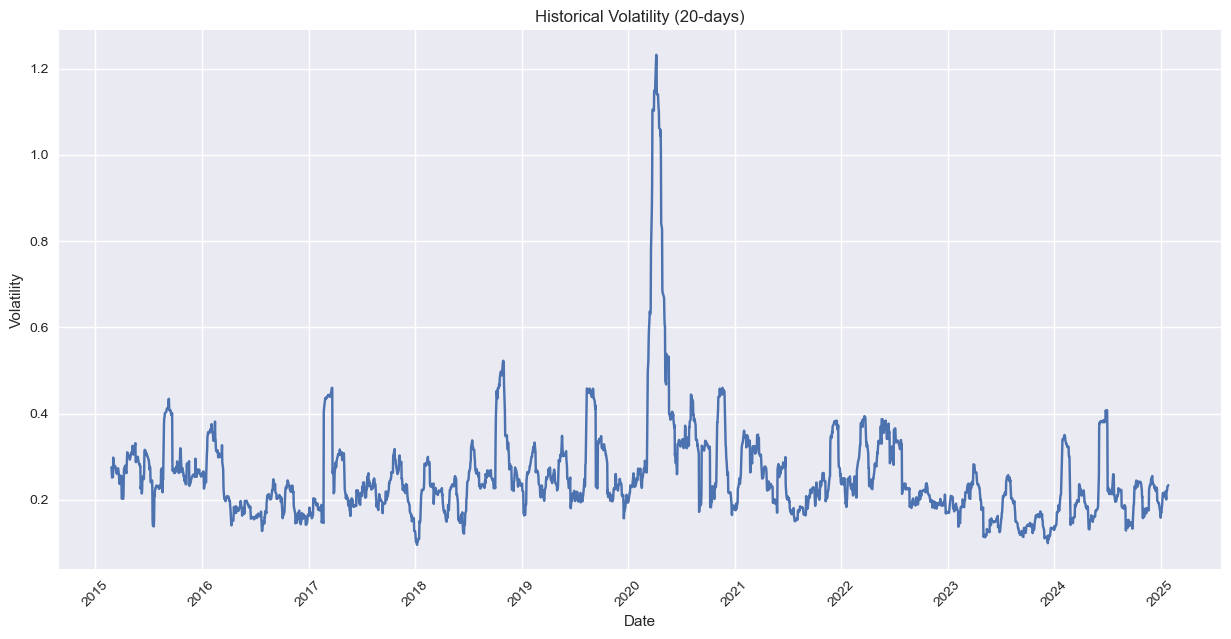

In [26]:
# Moving Averages
test = df.copy()
test['MA50'] = df['Close'].rolling(window=50).mean()
test['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(15, 7))
plt.plot(test['Date'], test['Close'], label='Close')
plt.plot(test['Date'], test['MA50'], label='50-day MA')
plt.plot(test['Date'], test['MA200'], label='200-day MA')
plt.title('Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Volatility (20-day rolling standard deviation)
test['Volatility'] = test['Returns'].rolling(window=20).std() * np.sqrt(252)
plt.figure(figsize=(15, 7))
plt.plot(test['Date'], test['Volatility'])
plt.title('Historical Volatility (20-days)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.show()

### Distribution Analysis

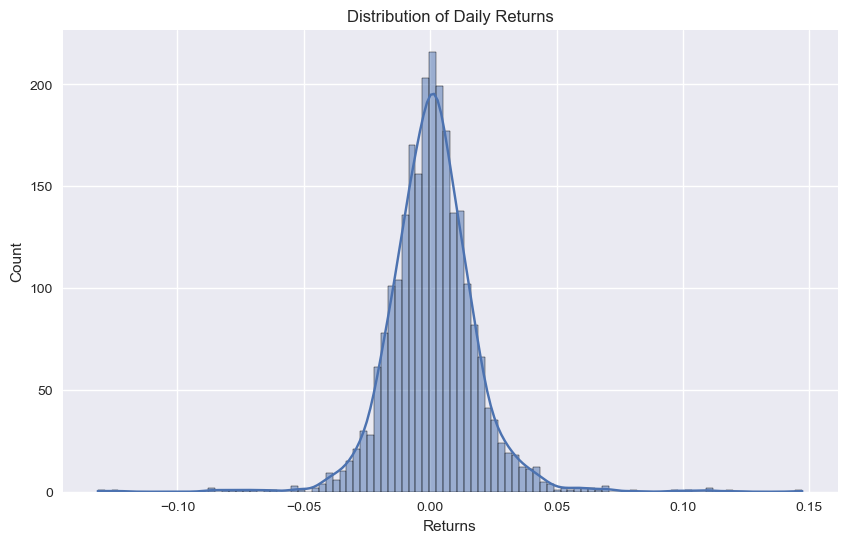

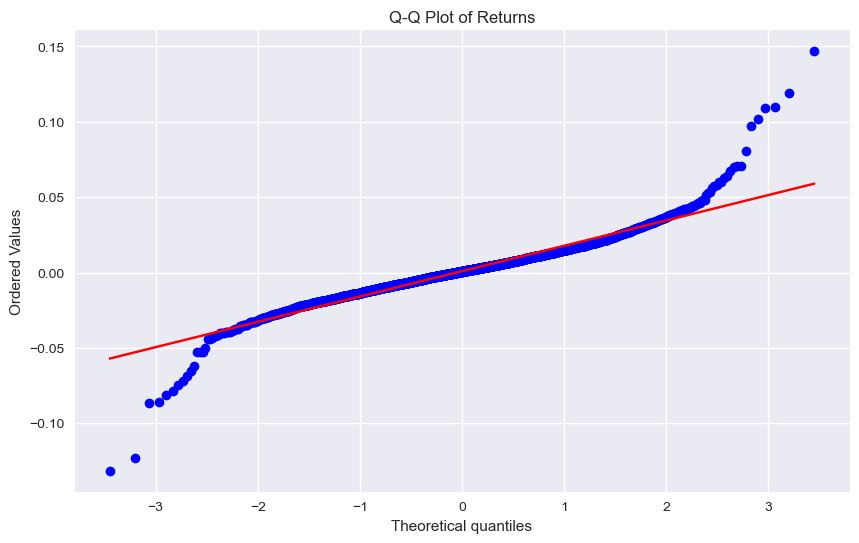

In [27]:
# Returns Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Returns'].dropna(), kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Returns')
plt.show()

# QQ Plot for Returns
plt.figure(figsize=(10, 6))
stats.probplot(df['Returns'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot of Returns')
plt.show()

### Correlation Analysis

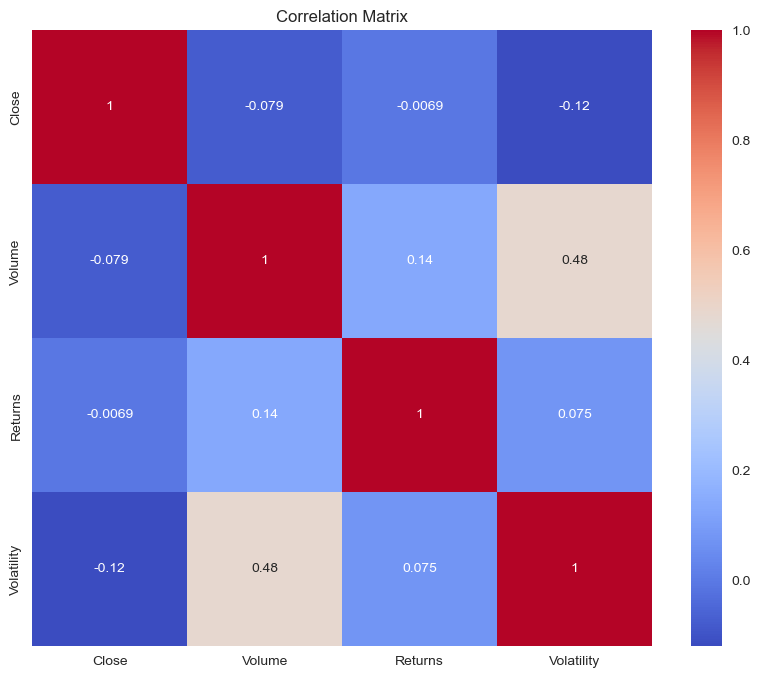

In [29]:
# Correlation Matrix
correlation_matrix = test[['Close', 'Volume', 'Returns', 'Volatility']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Data Preprocessing

In [30]:
df['Date'] = pd.to_datetime(df['Date'])  # Convert to datetime
df.set_index('Date', inplace=True)       # Set index
df['day_of_week'] = df.index.dayofweek   # Now this will work

In [ ]:
#Returns: Compute log returns for stationarity
df['log_returns'] = np.log(df['Close']).diff().dropna()

In [32]:
#Volatility: 20-day rolling standard deviation of returns
df['20D_vol'] = df['log_returns'].rolling(20).std()

In [33]:
#Moving Averages: 50-day and 200-day MAs
df['50D_MA'] = df['Close'].rolling(50).mean()
df['200D_MA'] = df['Close'].rolling(200).mean()

In [42]:
df.head(200)

,Date,Close,High,Low,Open,Volume,Returns,day_of_week,log_returns,20D_vol,50D_MA,200D_MA
0,2015-01-27,183.482697,185.061505,181.718137,184.277253,17939876,NaN,1,NaN,NaN,NaN,NaN
1,2015-01-28,187.156265,187.765098,182.873865,182.873865,19298126,0.020021,2,0.019824,NaN,NaN,NaN
2,2015-01-29,191.810150,192.862689,187.166581,187.207856,36117653,0.024866,3,0.024562,NaN,NaN,NaN
3,2015-01-30,188.889877,192.191970,187.599994,191.933988,21746801,-0.015225,4,-0.015342,NaN,NaN,NaN
4,2015-02-02,187.403931,189.849540,186.918936,189.054970,19302710,-0.007867,0,-0.007898,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
195,2015-11-10,195.297684,203.075732,193.932554,202.546614,11486238,-0.040052,1,-0.040876,0.017759,189.416834,NaN
196,2015-11-13,197.477661,198.641717,193.551600,193.668003,13682323,0.011162,4,0.011100,0.017883,189.687320,NaN
197,2015-11-16,197.742203,199.371884,195.720971,195.985537,15346549,0.001340,0,0.001339,0.017777,189.949339,NaN
198,2015-11-17,196.355896,198.715768,196.027852,198.535873,8588142,-0.007011,1,-0.007035,0.017885,190.253476,NaN


In [38]:
df = df.reset_index()

In [40]:
df.head()

,Date,Close,High,Low,Open,Volume,Returns,day_of_week,log_returns,20D_vol,50D_MA,200D_MA
0,2015-01-27,183.482697,185.061505,181.718137,184.277253,17939876,NaN,1,NaN,NaN,NaN,NaN
1,2015-01-28,187.156265,187.765098,182.873865,182.873865,19298126,0.020021,2,0.019824,NaN,NaN,NaN
2,2015-01-29,191.810150,192.862689,187.166581,187.207856,36117653,0.024866,3,0.024562,NaN,NaN,NaN
3,2015-01-30,188.889877,192.191970,187.599994,191.933988,21746801,-0.015225,4,-0.015342,NaN,NaN,NaN
4,2015-02-02,187.403931,189.849540,186.918936,189.054970,19302710,-0.007867,0,-0.007898,NaN,NaN,NaN


In [55]:
df_clean = df.dropna(subset=['50D_MA', '200D_MA', '20D_vol'])  # Drop rows with missing rolling features

In [57]:
df_clean = df_clean.drop(columns=['Returns'])

In [63]:
df_clean.head()

,Date,Close,High,Low,Open,Volume,day_of_week,log_returns,20D_vol,50D_MA,200D_MA
199,2015-11-18,193.022461,197.107253,192.588582,196.324151,11249222,2,-0.017122,0.018145,190.558883,191.292795
200,2015-11-19,197.837433,198.673445,194.133610,194.482832,12183206,3,0.024639,0.014738,190.919530,191.364569
201,2015-11-20,200.398376,201.657685,195.890287,197.678714,11304265,4,0.012862,0.015013,191.313195,191.430779
202,2015-11-23,201.858734,202.737074,200.260799,201.065065,10499517,0,0.007261,0.015109,191.812048,191.481022
203,2015-11-24,204.811218,205.636648,201.287290,201.700005,14806176,1,0.014521,0.015458,192.381380,191.560629


#### ADF Test

Null Hypothesis (H₀): The series has a unit root (non-stationary).

Alternative Hypothesis (H₁): The series is stationary.

If the p-value ≤ 0.05, reject H₀ (stationary). Otherwise, the series is non-stationary.

In [64]:
series = df_clean['log_returns']

In [65]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')  # Auto-selects optimal lag
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    if result[1] <= 0.05:
        print("Reject H₀: Data is stationary.")
    else:
        print("Fail to reject H₀: Data is non-stationary.")

# Run the test on your series
adf_test(series)

ADF Statistic: -14.433242387835653
p-value: 7.569179804390805e-27
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Reject H₀: Data is stationary.


1. **ADF Statistic**:
   - The value of **-14.43** is **far more negative** than all critical values (-3.433, -2.863, -2.567).  
   - This strongly rejects the null hypothesis (non-stationarity).

2. **p-value**:
   - A p-value of **7.57e-27** (≈ 0) is **much smaller than 0.05**.  
   - **Conclusion**: The data is stationary (no unit root).

### Check Autocorrelation

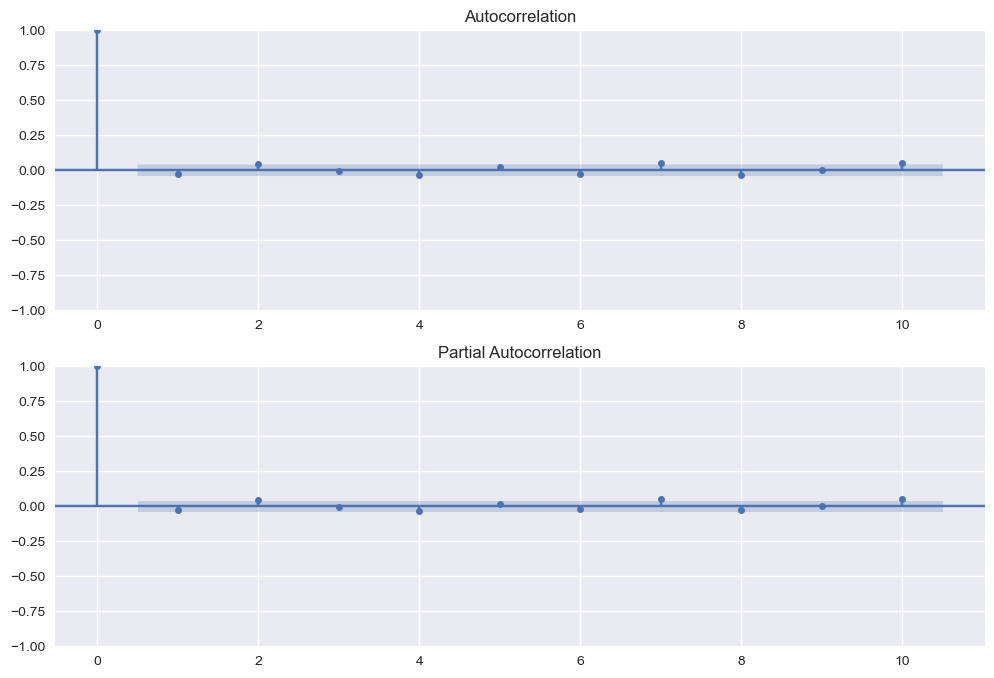

In [71]:
series = df_clean['log_returns']

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(series, lags=10, alpha=0.05, ax=ax1)   # 95% confidence interval
plot_pacf(series, lags=10, alpha=0.05, ax=ax2)  # 95% confidence interval
plt.show()

In [70]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print(acorr_ljungbox(df_clean['log_returns'], lags=20, return_df=True))

      lb_stat  lb_pvalue
1    1.398605   0.236957
2    5.855062   0.053529
3    6.013083   0.110975
4    8.767400   0.067184
5    9.750360   0.082626
6   11.353716   0.078041
7   17.498139   0.014452
8   19.638570   0.011793
9   19.683785   0.019967
10  25.174839   0.005024
11  33.463771   0.000442
12  35.328865   0.000415
13  35.589578   0.000687
14  36.595240   0.000849
15  36.601108   0.001447
16  36.924713   0.002149
17  37.341642   0.003024
18  43.037005   0.000791
19  44.173112   0.000894
20  44.211891   0.001410


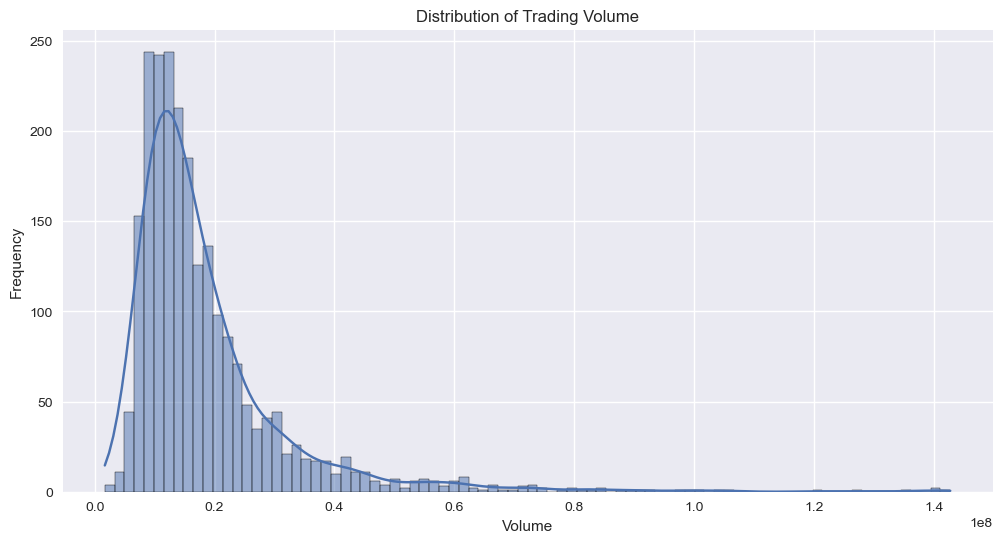

In [72]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_clean, x='Volume', kde=True)
plt.title('Distribution of Trading Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

In [73]:
df_clean['log_volume'] = np.log(df_clean['Volume'])

In [90]:
df_clean.head()

,Date,Close,High,Low,Open,Volume,day_of_week,log_returns,20D_vol,50D_MA,200D_MA,log_volume
199,2015-11-18,193.022461,197.107253,192.588582,196.324151,11249222,2,-0.017122,0.018145,190.558883,191.292795,16.235810
200,2015-11-19,197.837433,198.673445,194.133610,194.482832,12183206,3,0.024639,0.014738,190.919530,191.364569,16.315569
201,2015-11-20,200.398376,201.657685,195.890287,197.678714,11304265,4,0.012862,0.015013,191.313195,191.430779,16.240691
202,2015-11-23,201.858734,202.737074,200.260799,201.065065,10499517,0,0.007261,0.015109,191.812048,191.481022,16.166840
203,2015-11-24,204.811218,205.636648,201.287290,201.700005,14806176,1,0.014521,0.015458,192.381380,191.560629,16.510555


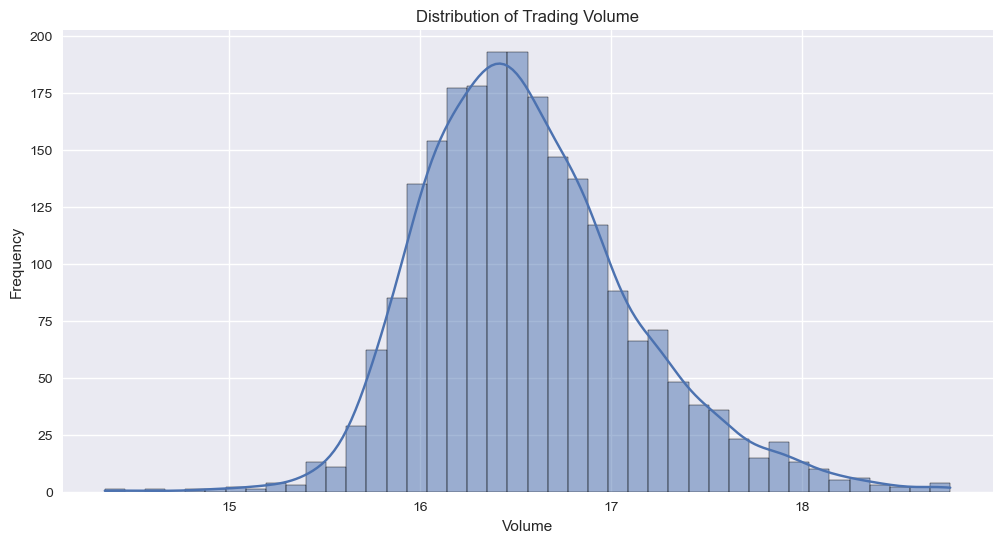

In [80]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_clean, x='log_volume', kde=True)
plt.title('Distribution of Trading Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

In [91]:
scaler = RobustScaler()
features_to_scale = ['log_volume', '20D_vol', '50D_MA', '200D_MA']
df_clean[features_to_scale] = scaler.fit_transform(df_clean[features_to_scale])

In [93]:
df_clean.head()

,Date,Close,High,Low,Open,Volume,day_of_week,log_returns,20D_vol,50D_MA,200D_MA,log_volume
199,2015-11-18,193.022461,197.107253,192.588582,196.324151,11249222,2,-0.017122,0.650048,-0.670418,-0.574864,-0.380159
200,2015-11-19,197.837433,198.673445,194.133610,194.482832,12183206,3,0.024639,0.084389,-0.669931,-0.574770,-0.266173
201,2015-11-20,200.398376,201.657685,195.890287,197.678714,11304265,4,0.012862,0.130146,-0.669400,-0.574684,-0.373183
202,2015-11-23,201.858734,202.737074,200.260799,201.065065,10499517,0,0.007261,0.146052,-0.668728,-0.574618,-0.478725
203,2015-11-24,204.811218,205.636648,201.287290,201.700005,14806176,1,0.014521,0.203976,-0.667960,-0.574515,0.012486


## Model Building

In [94]:
# Shift returns backward by 1 day to predict "tomorrow’s return"
df_clean['target'] = df_clean['log_returns'].shift(-1)

# Drop NaN rows (last row will have NaN for `target`)
df_clean = df_clean.dropna()

In [96]:
df_clean.head()

,Date,Close,High,Low,Open,Volume,day_of_week,log_returns,20D_vol,50D_MA,200D_MA,log_volume,target
199,2015-11-18,193.022461,197.107253,192.588582,196.324151,11249222,2,-0.017122,0.650048,-0.670418,-0.574864,-0.380159,0.024639
200,2015-11-19,197.837433,198.673445,194.133610,194.482832,12183206,3,0.024639,0.084389,-0.669931,-0.574770,-0.266173,0.012862
201,2015-11-20,200.398376,201.657685,195.890287,197.678714,11304265,4,0.012862,0.130146,-0.669400,-0.574684,-0.373183,0.007261
202,2015-11-23,201.858734,202.737074,200.260799,201.065065,10499517,0,0.007261,0.146052,-0.668728,-0.574618,-0.478725,0.014521
203,2015-11-24,204.811218,205.636648,201.287290,201.700005,14806176,1,0.014521,0.203976,-0.667960,-0.574515,0.012486,0.021418


In [98]:
# Lagged returns (1-day, 2-day, etc.)
df_clean['log_returns_lag1'] = df_clean['log_returns'].shift(1)
df_clean['log_returns_lag2'] = df_clean['log_returns'].shift(2)

# Lagged volatility (e.g., 20-day rolling std)
df_clean['20D_volatility'] = df_clean['log_returns'].rolling(20).std().shift(1)  # Avoid look-ahead

# Ensure all features are lagged appropriately
df_clean = df_clean.dropna()

C:\Users\linar\AppData\Local\Temp\ipykernel_15984\4178841275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['log_returns_lag1'] = df_clean['log_returns'].shift(1)
C:\Users\linar\AppData\Local\Temp\ipykernel_15984\4178841275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['log_returns_lag2'] = df_clean['log_returns'].shift(2)
C:\Users\linar\AppData\Local\Temp\ipykernel_15984\4178841275.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [99]:
# Drop non-predictive columns and future data
features = [
    'log_volume', '20D_vol', '50D_MA', '200D_MA', 
    'log_returns_lag1', 'log_returns_lag2', '20D_volatility'
]
X = df_clean[features]
y = df_clean['target']  # Target = tomorrow's return

In [100]:
split_idx = int(0.8 * len(X))  # 80% training, 20% testing
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [104]:
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,          # Prevent overfitting
    subsample=0.8,        # Stochastic gradient boosting
    colsample_bytree=0.8, # Feature randomness
    early_stopping_rounds=50,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50
)

[0]	validation_0-rmse:0.01276
[50]	validation_0-rmse:0.01274
[100]	validation_0-rmse:0.01273
[150]	validation_0-rmse:0.01271
[178]	validation_0-rmse:0.01273


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [107]:
# Predictions
y_pred = model.predict(X_test)

# Regression metrics
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

# Directional accuracy (critical for trading)
direction_accuracy = np.mean(np.sign(y_pred) == np.sign(y_test))
print(f"Directional Accuracy: {direction_accuracy * 100:.2f}%")

RMSE: 0.0127
MAE: 0.0092
R²: 0.0073
Directional Accuracy: 51.79%


In [114]:
# Split into train (60%), validation (20%), and test (20%)
train_idx = int(0.6 * len(X))
val_idx = int(0.8 * len(X))

X_train, X_val, X_test = X.iloc[:train_idx], X.iloc[train_idx:val_idx], X.iloc[val_idx:]
y_train, y_val, y_test = y.iloc[:train_idx], y.iloc[train_idx:val_idx], y.iloc[val_idx:]

In [115]:
param_grid = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 2, 5],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
    'n_estimators': [1000]  # Let early stopping determine actual used trees
}

model = XGBRegressor(
    objective='reg:squarederror',
    early_stopping_rounds=50,
    random_state=42
)

# Time-series aware cross-validation
tscv = TimeSeriesSplit(n_splits=3)

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

# For each split, validation fold comes after training fold
search.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print("Best parameters:", search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}


In [116]:
best_model = search.best_estimator_

# Train on full training data (train + validation)
final_train = pd.concat([X_train, X_val])
final_target = pd.concat([y_train, y_val])

best_model.fit(
    final_train, final_target,
    eval_set=[(X_test, y_test)],  # Monitor performance on test set
    verbose=50
)

[0]	validation_0-rmse:0.01276
[50]	validation_0-rmse:0.01275
[78]	validation_0-rmse:0.01276


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [117]:
y_pred = best_model.predict(X_test)

print(f"Improved RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"Improved Directional Accuracy: {np.mean(np.sign(y_pred) == np.sign(y_test.values)) * 100:.2f}%")

Improved RMSE: 0.0127
Improved Directional Accuracy: 52.91%


In [120]:
# Save model in binary format
best_model.save_model('xgb_model.model')

c:\Users\linar\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:36:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
